## 0.0) Importando Bibliotecas

In [5]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!{sys.executable} -m pip install chardet
import chardet

## 0.1) Carregando os Dados

Carregando dataset de imóveis

In [6]:
df_imoveis = pd.read_csv('./dados/dados_imoveis.csv')
df_imoveis.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000


Carregando dataset do IBGE

In [7]:
# Olhar os 10000 primeiros bytes do arquivo para deduzir o enconding dos caracteres
# para então importar corretamente os dados em um Pandas Dataframe
with open("./dados/basico_sp1.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

print(result)

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [8]:
# Importando a base de dados do IBGE
df_ibge = pd.read_csv( './dados/basico_sp1.csv', sep=";", encoding='utf-8', thousands=".", decimal=",", engine="python" )
df_ibge.dropna(how='all', axis=1, inplace=True)
df_ibge.head()

,Cod_setor,Cod_Grandes Regi�es,Nome_Grande_Regiao,Cod_UF,Nome_da_UF,Cod_meso,Nome_da_meso,Cod_micro,Nome_da_micro,Cod_RM,...,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
0,355030801000001,3,Regi�o Sudeste,35,S�o Paulo,3515,Metropolitana de S�o Paulo,35061,S�o Paulo,20,...,3.01,2.32,2091.32,8532451.78,2164.55,8673276.78,1227.41,4285771.99,1713.75,5152087.86
1,355030801000002,3,Regi�o Sudeste,35,S�o Paulo,3515,Metropolitana de S�o Paulo,35061,S�o Paulo,20,...,2.98,2.09,1650.09,3983441.31,1717.44,4030519.99,1045.78,2572133.32,1468.08,2991546.94
2,355030801000003,3,Regi�o Sudeste,35,S�o Paulo,3515,Metropolitana de S�o Paulo,35061,S�o Paulo,20,...,3.31,3.08,1280.43,5474593.06,2349.53,7553913.02,902.97,2735492.52,1786.79,3837674.74
3,355030801000004,3,Regi�o Sudeste,35,S�o Paulo,3515,Metropolitana de S�o Paulo,35061,S�o Paulo,20,...,3.16,2.26,1119.59,3572955.10,1859.13,4567289.50,869.09,2122409.02,1567.41,2735383.24
4,355030801000005,3,Regi�o Sudeste,35,S�o Paulo,3515,Metropolitana de S�o Paulo,35061,S�o Paulo,20,...,3.14,2.35,1416.90,2240207.58,1581.66,2240109.39,917.71,1570047.75,1356.35,1725877.85


# 1) Descrição dos Dados

In [9]:
df_imoveis.head()

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000


In [10]:
df_imoveis.shape

(10008, 8)

In [11]:
df_imoveis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rua        6574 non-null   object
 1   Bairro     9996 non-null   object
 2   Cidade     10008 non-null  object
 3   Metragem   10008 non-null  int64 
 4   Quartos    10008 non-null  int64 
 5   Banheiros  10008 non-null  int64 
 6   Vagas      10008 non-null  int64 
 7   Valor      10008 non-null  object
dtypes: int64(4), object(4)
memory usage: 625.6+ KB


### Valores Nulos

In [13]:
df_imoveis.isna().sum()

Rua          3434
Bairro         12
Cidade          0
Metragem        0
Quartos         0
Banheiros       0
Vagas           0
Valor           0
dtype: int64

As variáveis `Rua` e `Bairro` possuem valores nulos que precisam ser tratados posteriormente.

### Tipos dos dados

In [24]:
df_imoveis.dtypes

Rua          object
Bairro       object
Cidade       object
Metragem      int64
Quartos       int64
Banheiros     int64
Vagas         int64
Valor        object
dtype: object

O tipo da coluna `Valor` está errado, devendo ser transformada para numérica de ponto flutuante.

In [29]:
df_imoveis['Valor'].sample(10)

5663    R$ 28.000\n                      /Mês
2809                             R$ 1.600.000
1681                             R$ 3.000.000
5948                             R$ 7.500.000
4063                             R$ 1.850.000
3973                             R$ 2.970.000
4003                             R$ 2.800.000
8649                             R$ 6.500.000
8771                               R$ 999.000
8908                             R$ 1.000.000
Name: Valor, dtype: object

### Resolvendo Tipos de Dados Incorretos

**Variável `Valor`**

# Calculando Estatísticas

In [34]:
df_imoveis.describe().rename({'50%': 'Mediana', 'mean': 'Média'}).T

,count,Média,std,min,25%,Mediana,75%,max
Metragem,10008.0,442.300659,7515.379389,10.0,173.0,290.0,460.25,750000.0
Quartos,10008.0,3.483114,1.064200,1.0,3.0,3.0,4.00,16.0
Banheiros,10008.0,3.879097,1.988467,1.0,2.0,4.0,5.00,40.0
Vagas,10008.0,4.097222,2.824014,1.0,2.0,4.0,5.00,50.0


# Imprimindo BoxPlots

<AxesSubplot:>

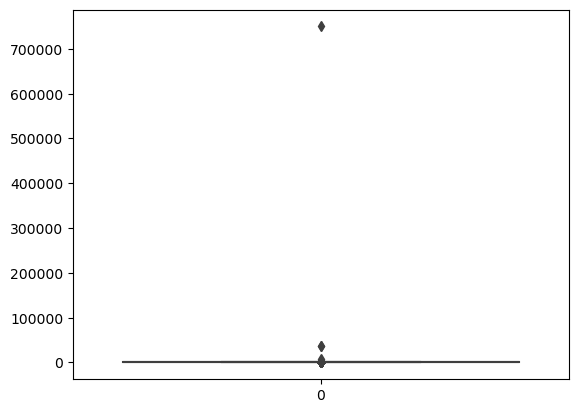

In [38]:
sns.boxplot(df_imoveis['Metragem'])

<AxesSubplot:>

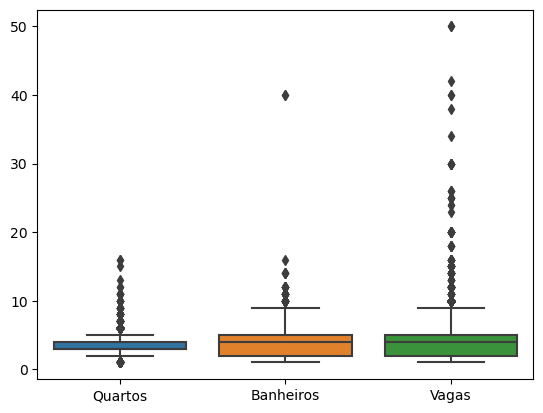

In [39]:
sns.boxplot(df_imoveis.drop(columns=['Metragem']))

<AxesSubplot:>

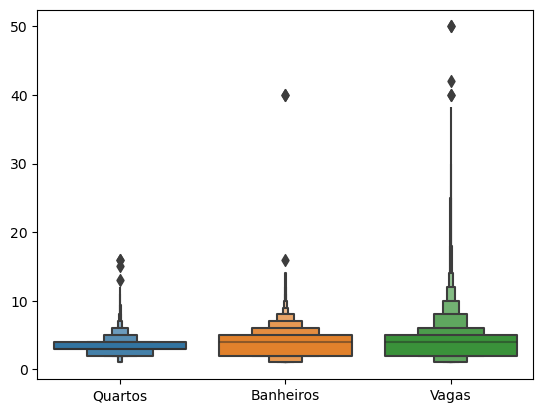

In [40]:
sns.boxenplot(df_imoveis.drop(columns=['Metragem']))

<AxesSubplot:>

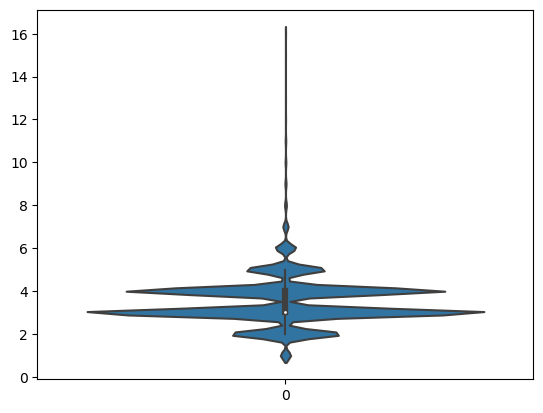

In [43]:
sns.violinplot(df_imoveis['Quartos'])